# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Business Requirements

In a used car dealership, pricing the car correctly is crucial to maximizing profit from the sale. This profitability is influenced by accurately identifying the features and attributes that are in demand among buyers. Key factors include the car’s brand name, unique features, and any attributes that are not readily available in the market. Additionally, market trends and consumer preferences can significantly impact the sale of a car.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Data Quality Steps

We need to understand what are the available features in the dataset. Is there any missing values? If there are missing values , how relevant are those? Is there an option to replace empty cell using information from another cell or is it better to be dropped? Is any column identical to another column, if so can one of these be dropped.Is there any insignifficant fields which is not useful for modeling? What are the catogorical columns that can be transformed with proper encoding?

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [2]:
cars = pd.read_csv('data/vehicles.csv')

In [4]:
cars.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Column Id and VIN are for identification purpose only so this can be dropped. Region and State are almost identical columns here, so column Region can be dropped.Size column is missing 70% of its values.Model column contains vast amount sub category for manufacture columns and many of those contains junk values along with it, so dropping this column as well.

In [3]:
cars.drop(['id','VIN', 'region', 'model', 'size'], axis=1, inplace=True)

year and manufacture data is missing for so many cars so decided to drop these records.

In [4]:
cars.dropna(subset = ['manufacturer'],inplace=True)
cars.dropna(subset = ['year'],inplace=True)

Cylinders column contains cylinders along with the number, so removing those strings. Cells with other in it is replaced by getting mode from this column.

In [ ]:
cars["cylinders"] = cars['cylinders'].str.replace(' cylinders', '')
cars["cylinders"].fillna(cars["cylinders"].mode()[0], inplace=True)
cars["cylinders"] = cars['cylinders'].str.replace('other', cars["cylinders"].mode()[0])
cars["cylinders"] = pd.to_numeric(cars['cylinders'])

Missing values cells are replaced with other or by getting the mean/mode from the column

In [5]:
cars['drive'].fillna('unknown_drive', inplace=True)
cars["title_status"].fillna(cars["title_status"].mode()[0], inplace=True)
cars["fuel"].fillna('other', inplace=True)
cars["odometer"].fillna(cars["odometer"].mean(), inplace=True)
cars['transmission'].fillna('unknown_transmission', inplace=True )
cars['paint_color'].fillna('unknown_color', inplace=True)
cars['type'].fillna('unknown_type',inplace=True)
cars['condition'].fillna('unknown_condition',inplace=True)

#### Is there any Outliers ?

##### Columns year, odometer and price have got outliers when checked using plots so removed those outliers from these columns

In [6]:
# Removing outliers from year column
std = cars['year'].std() 
mean = cars['year'].mean()
print(std, mean)
cars = cars[cars['year']>= mean-2*std]
cars = cars[cars['year']<= mean+2*std]

8.936714075376884 2011.508354755784


In [7]:
# Removing outliers from odometer column
std = cars['odometer'].std() 
mean = cars['odometer'].mean()
print(std, mean)
cars = cars[cars['odometer']<= mean+2*std]
cars = cars[cars['odometer']> 0]

148391.53105457604 94819.67703110355


In [8]:
cars.drop_duplicates(inplace=True)

In [9]:
# finding outliers from price column
def outliers_filter(df, column):
    factor = 1.5
    first_quartile = df[column].quantile(.25)
    third_quartile = df[column].quantile(.75)
    iqr = third_quartile - first_quartile
    lower = first_quartile - factor*iqr
    upper = third_quartile + factor*iqr
    print( f' lower: { lower }, upper: { upper }')
    return

outliers_filter(cars, 'price')

 lower: -22885.0, upper: 53075.0


In [10]:
# Removing outliers from price column. A cars price less than 500 does not seems like a valid price so removing those.
cars= cars[(cars['price'] < 70000) & (cars['price'] > 500)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


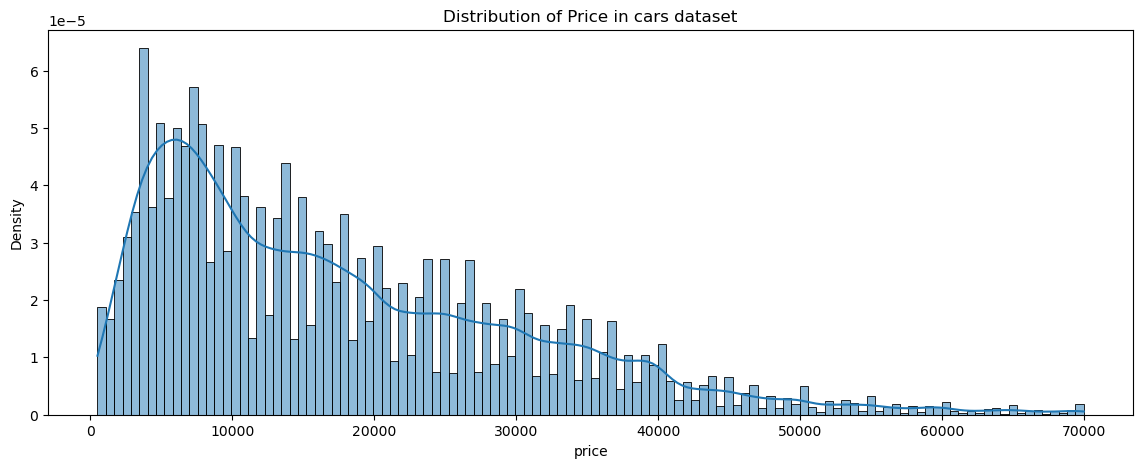

In [40]:
plt.figure(figsize=(14,5))
sns.histplot(cars['price'], kde=True, stat="density").set(title = 'Distribution of Price in cars dataset')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


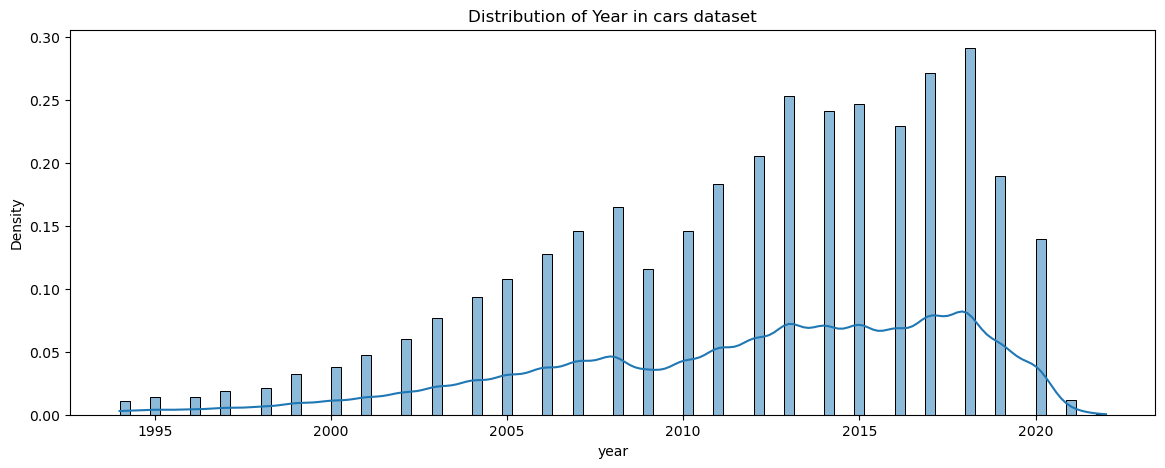

In [35]:
plt.figure(figsize=(14,5))
sns.histplot(cars["year"], kde=True, stat="density").set(title = 'Distribution of Year in cars dataset')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


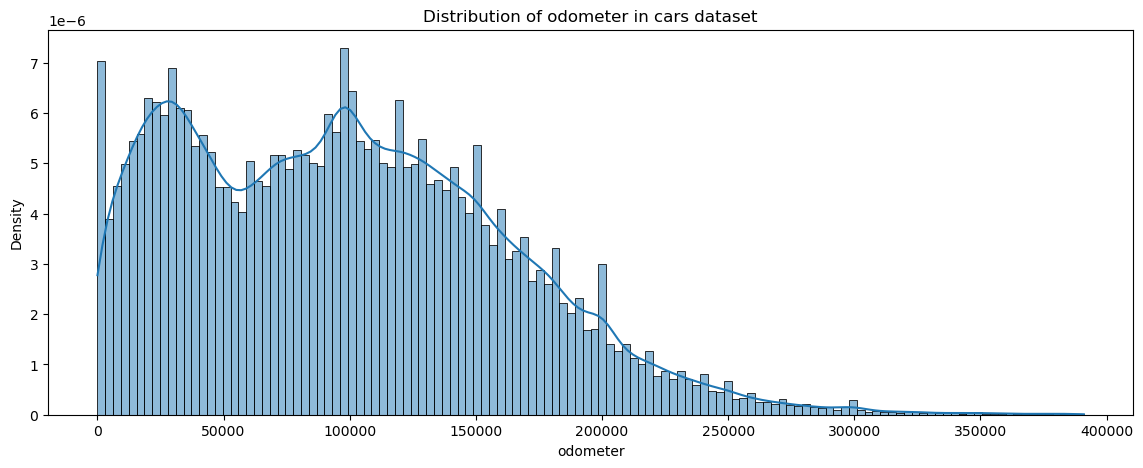

In [43]:
plt.figure(figsize=(14,5))
sns.histplot(cars['odometer'], kde=True, stat="density").set(title = 'Distribution of odometer in cars dataset')
plt.show()

In [26]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245171 entries, 27 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         245171 non-null  int64  
 1   year          245171 non-null  float64
 2   manufacturer  245171 non-null  object 
 3   condition     245171 non-null  object 
 4   cylinders     245171 non-null  int64  
 5   fuel          245171 non-null  object 
 6   odometer      245171 non-null  float64
 7   title_status  245171 non-null  object 
 8   transmission  245171 non-null  object 
 9   drive         245171 non-null  object 
 10  type          245171 non-null  object 
 11  paint_color   245171 non-null  object 
 12  state         245171 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 26.2+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [12]:
X = cars.drop('price', axis =1)

In [13]:
y = cars['price']

In [14]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=22)

In [15]:
# creating OrdinalEncoder to  change categorical values to numerical values
col_transformer_ordinal = make_column_transformer(
                                          (OrdinalEncoder(), ['manufacturer','state','condition','cylinders','fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']), 
                                          remainder='passthrough',
                                         verbose_feature_names_out=False)

##### Ridge Regression Model

In [48]:
def get_training_and_test_MSE_for_model_with_alpha(alpha):        
    scaled_ridge_model = Pipeline([ 
        ('transformer', col_transformer_ordinal ),
        ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
        ('scale', StandardScaler()),
        ('ridge', Ridge(alpha = alpha))    
    ])
    scaled_ridge_model.fit(X_train, y_train)
    train_error = mean_squared_error(scaled_ridge_model.predict(X_train), y_train)
    test_error = mean_squared_error(scaled_ridge_model.predict(X_test), y_test)
    return alpha, train_error, test_error

In [49]:
results = [get_training_and_test_MSE_for_model_with_alpha(alpha) \
             for alpha in 10**np.linspace(-5, 4, 100)]
results_df = pd.DataFrame(results, columns = ["alpha", "Train MSE", "Test MSE"])

In [51]:
print(results_df)

           alpha     Train MSE      Test MSE
0       0.000010  4.559723e+07  4.619935e+07
1       0.000012  4.560007e+07  4.620229e+07
2       0.000015  4.560250e+07  4.620482e+07
3       0.000019  4.560456e+07  4.620697e+07
4       0.000023  4.560630e+07  4.620878e+07
..           ...           ...           ...
95   4328.761281  5.515925e+07  5.544944e+07
96   5336.699231  5.537664e+07  5.566865e+07
97   6579.332247  5.559978e+07  5.589574e+07
98   8111.308308  5.583234e+07  5.613453e+07
99  10000.000000  5.607929e+07  5.639014e+07

[100 rows x 3 columns]


In [173]:
results_df.sort_values("Test MSE").iloc[0, :]

alpha        1.000000e-05
Train MSE    4.559723e+07
Test MSE     4.619935e+07
Name: 0, dtype: float64

In [174]:
scaled_ridge_model = Pipeline([ 
        ('transformer', col_transformer_ordinal ),
        ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
        ('scale', StandardScaler()),
        ('ridge', Ridge(alpha = .00001))    
    ])

In [175]:
scaled_ridge_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['manufacturer', 'state',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color'])],
                                   verbose_feature_names_out=False)),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scale', StandardScaler()), ('ridge', Ridge(alpha=1e-05))])

##### Calculating Permutation Importance on Ridge Regression Model :

In [178]:
ridge_permutn_result = permutation_importance(scaled_ridge_model, X_test, y_test, n_repeats=10, random_state=40)

In [181]:
importance_ridge = ridge_permutn_result.importances_mean

ridge_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importance_ridge
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance of Features with Ridge Model:")
print(ridge_importance_df)


Permutation Importance of Features with Ridge Model:
         Feature  Importance
0           year    0.481014
5       odometer    0.140820
3      cylinders    0.128275
8          drive    0.116971
4           fuel    0.105381
9           type    0.021059
7   transmission    0.019974
2      condition    0.018805
6   title_status    0.016871
1   manufacturer    0.007624
10   paint_color    0.004435
11         state    0.002878


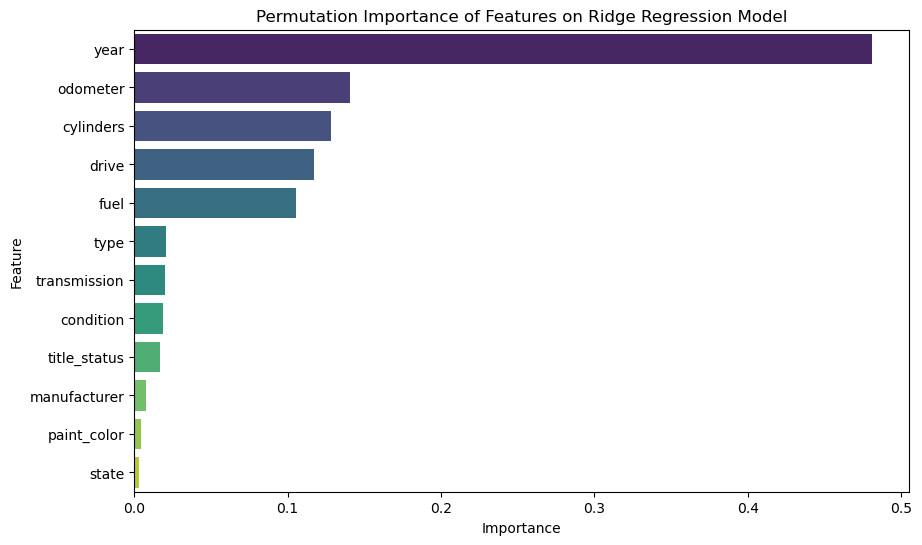

In [183]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=ridge_importance_df, palette='viridis')
plt.title('Permutation Importance of Features on Ridge Regression Model')
plt.show()

##### LinearRegression

In [156]:
linear_model = Pipeline([    
        ('transformer', col_transformer_ordinal ),
        ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())    
    ])

In [157]:
linear_model.fit(X_train, y_train)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['manufacturer', 'state',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color'])],
                                   verbose_feature_names_out=False)),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [158]:
linear_train_mse = mean_squared_error(linear_model.predict(X_train), y_train)
linear_test_mse = mean_squared_error(linear_model.predict(X_test), y_test)
print("linear model Train MSE : " , linear_train_mse)
print("linear Model Test MSE : " , linear_test_mse)

linear model Train MSE :  45515104.53272708
linear Model Test MSE :  46125577.124487795


##### Calculating permutation Importance on Linear Regression model :

In [159]:
linear_permutn_result = permutation_importance(linear_model, X_test, y_test, n_repeats=10, random_state=42)

In [161]:
importance_linear = linear_permutn_result.importances_mean

linear_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importance_linear
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance of Features:")
print(linear_importance_df)


Permutation Importance of Features:
         Feature  Importance
0           year    0.486096
5       odometer    0.161670
3      cylinders    0.129302
8          drive    0.116632
4           fuel    0.105365
9           type    0.021103
7   transmission    0.019170
2      condition    0.018244
6   title_status    0.017197
1   manufacturer    0.007829
10   paint_color    0.004707
11         state    0.002932


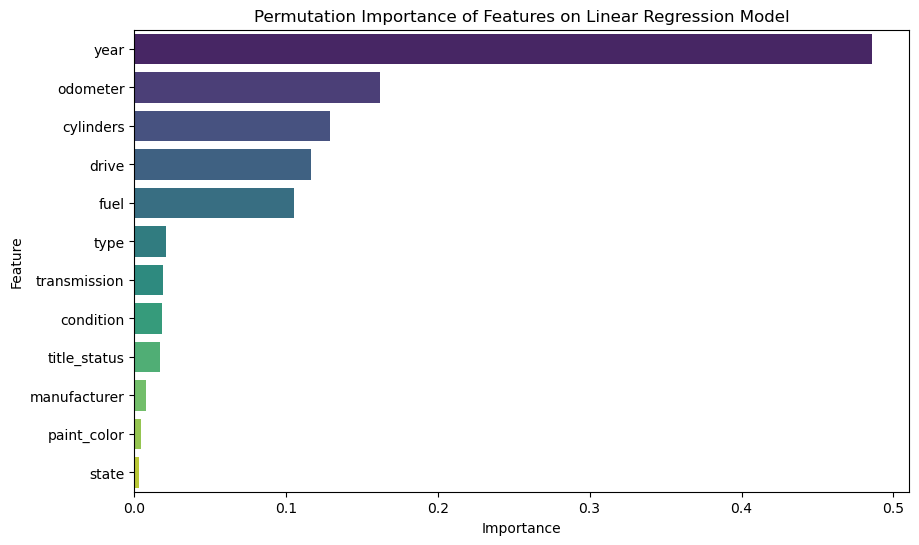

In [162]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=linear_importance_df, palette='viridis')
plt.title('Permutation Importance of Features on Linear Regression Model')
plt.show()

##### GridSearchCV

In [16]:
poly_linear_model = Pipeline([
        ('transformer', col_transformer_ordinal),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias=False)),
        ('model', LinearRegression())   
    ])

In [17]:
parameters_to_try = {'poly__degree':  list(range(2,4))}

In [18]:
model_finder = GridSearchCV(estimator = poly_linear_model, 
                               param_grid = parameters_to_try,
                               )

In [21]:
model_finder.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['manufacturer',
                                                                          'state',
                                                                          'condition',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'type',
                                                                          'paint_color'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaler', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model', LinearRegression())]),
             param_grid={'poly__degree': [2, 3]})

In [22]:
best_model = model_finder.best_estimator_
best_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['manufacturer', 'state',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

In [29]:
print(f"Dev MSE for our best Linear Regression model: {model_finder.best_score_}")

Dev MSE for our best Linear Regression model: 0.7315653754113207


In [25]:
gridsearch_train_mse = mean_squared_error(best_model.predict(X_train), y_train)
gridsearch_test_mse = mean_squared_error(best_model.predict(X_test), y_test)
print("Gridsearch sequential  model Train MSE : " , gridsearch_train_mse)
print("Gridsearch sequential  Model Test MSE : " , gridsearch_test_mse)

Gridsearch sequential  model Train MSE :  45515104.53272296
Gridsearch sequential  Model Test MSE :  46125577.12443226


In [27]:
best_selector = model_finder.best_estimator_.named_steps['poly']
print(best_selector.degree)


3


In [53]:
feature_list = best_model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
     best_model[-1].coef_,
     columns= ["Coefficients"],
     index=feature_list,
)
coefs.sort_values(by=['Coefficients'], ascending=False).head(10)

,Coefficients
drive,6542.233855
year,5353.184702
drive^2,3335.438736
condition,2581.907182
cylinders,2089.949499
transmission,1897.097828
year^2,1339.616058
cylinders drive^2,1044.595106
drive^2 year,1016.056413
paint_color^2,962.511636


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

There were some junk values and outliers in the data set, so revisited data preperation step to clean up those.The data set was huge and was heavy to do some of the modeling. So went back to change encoding to avoid additional column creation during transformation by onehot encoding and to remove some more outliers. I had to Restricted modeling with higher polynomial degree than 3 but calculated Ridge regression with different alpha values.GridSearchCV is done with polynimial degree as param grid and result showed degree 3 is better than degree 2. Ridge Regression and Linear Regression showed almost similar results. Important features shown from these modeling were same.  

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

1. Based on the clear analysis of the data and modeling these are the important factors that help to maximice price

2. Newer vehicle - If the year of the car is latest then it yields more price.

3. Odometer showing lower reading - If the car is less driven since it is brought then it is better.

4. Cars with higher number of cylinders - The price is highers for cars with more number of cylinders

5. Drive category -  forward or rear wheel drive are better to maximize the price.

6. Fuel - cars with gas has higher price value

7. Transmission - cars with automatic transmission will yield more price

8. Condition and Title status are the next two factors that affects the price.